In [10]:
%load_ext autoreload
%autoreload 2

import gudhi
import numpy as np

from functions.data_loading import get_filtered_data_range, get_data_range, get_flight_persistence, get_removed_outliers
from functions.data_filtering import complete_flight_filter
from functions.data_filtering import filter_by_bools, filter_flights
from functions.objects import PersistenceData

from datetime import datetime
from collections import Counter
from tqdm import tqdm
from traffic.core import Traffic, Flight
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
origin = "oslo"
destination = "bergen"

#unfiltered_flights, file_name = get_data_range(origin, destination, datetime(year=2023, month=1, day=1), datetime(year=2024, month=1, day=1), load_results=True)
file_name = "oslo-bergen-2023-01-01-2024-01-01.pkl"
#filtered_flights, file_name = get_filtered_data_range(None, file_name, complete_flight_filter(origin, destination, 0.75), load_results=True)
file_name = "complete_flights/oslo-bergen-2023-01-01-2024-01-01.pkl"
trees, paths, file_name = get_flight_persistence(None, file_name, load_results=True)

In [4]:
pers_data = PersistenceData(trees, paths, "LL")

In [5]:
condensed_distance_matrix = []

for i in tqdm(range(len(trees))):
    for j in range(i+1, len(trees)):
        tree_i = trees[i]
        tree_j = trees[j]
        dist = gudhi.bottleneck_distance(tree_i, tree_j, 0.0001)
        condensed_distance_matrix.append(dist)

100%|██████████| 6948/6948 [00:37<00:00, 182.88it/s] 


In [6]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import sys
sys.setrecursionlimit(10000)

Z = linkage(condensed_distance_matrix, "complete")

#fig = plt.figure(figsize=(100, 10))
#dn = dendrogram(Z)

clustering = fcluster(Z, t=1.1, criterion='inconsistent', depth=2)
#clustering = fcluster(Z, t=10, criterion='maxclust', depth=2)

In [7]:
for i in range(1, len(np.unique(clustering))+1):
    print(f"{i}: {sum(clustering == i)}")


1: 3
2: 7
3: 2
4: 2
5: 4
6: 3
7: 3
8: 2
9: 3
10: 6887
11: 14
12: 2
13: 2
14: 2
15: 3
16: 1
17: 8


3


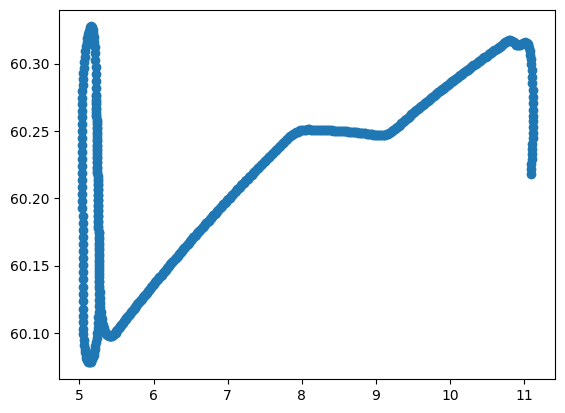

In [32]:
bool_array = clustering == 1

loopy_flight_cluster = filter_flights(filter_by_bools(bool_array), pers_data.paths)
loopy_flight_cluster_pers = list(filter(filter_by_bools(bool_array), pers_data.paths))
print(len(loopy_flight_cluster))
loopy_flight = loopy_flight_cluster[2]
plt.scatter(loopy_flight[:,1], loopy_flight[:,0])

In [80]:
from sklearn import preprocessing
from sklearn.cluster import DBSCAN, KMeans, OPTICS

dbscan = DBSCAN(eps=0.1, min_samples=2)
k_means = KMeans(n_clusters=2, random_state=0)
optics = OPTICS()

data = pers_data.stats

normalizer = preprocessing.StandardScaler()
data = normalizer.fit_transform(data)

DB_clustering = dbscan.fit_predict(pers_data.stats)
print(np.unique(DB_clustering))

k_clustering = KMeans(n_clusters=2, random_state=0).fit_predict(pers_data.stats)
print(np.unique(k_clustering))

optic_clustering = OPTICS().fit_predict(pers_data.stats)
print(np.unique(optic_clustering))

[-1  0  1  2  3  4  5  6  7]
[0 1]
[-1  0  1  2  3  4  5  6  7  8  9]


3


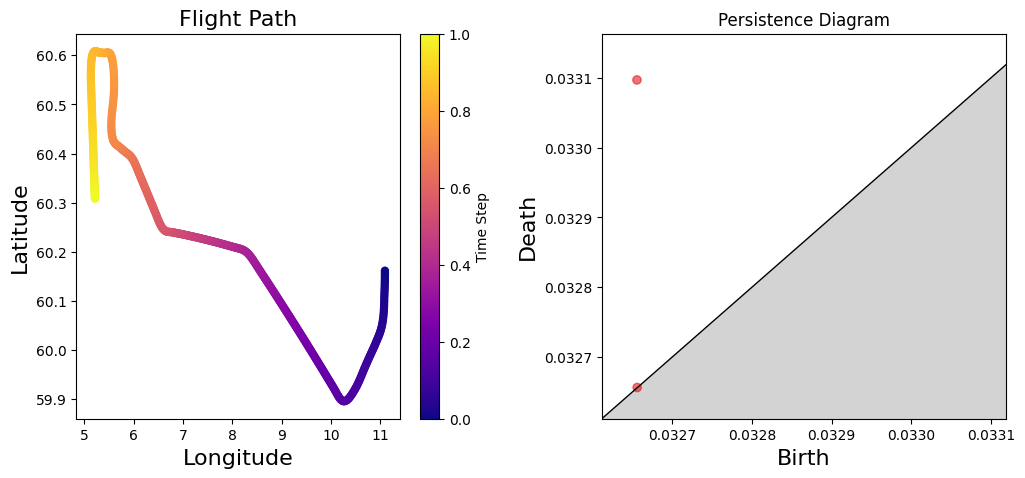

In [89]:
cluster = np.where(DB_clustering == 2)[0]
print(len(cluster))

fig = pers_data.plot_diagram(cluster[2])

12


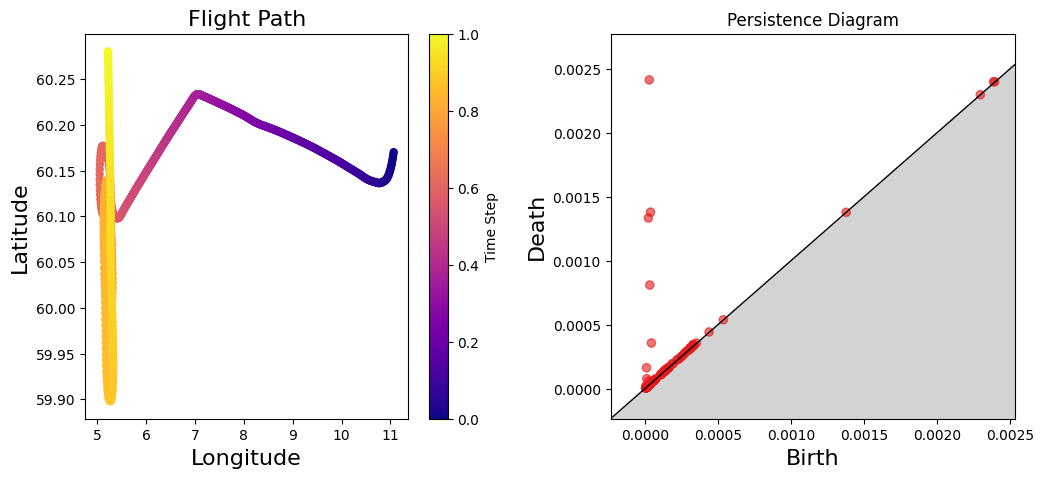

In [90]:
cluster = np.where(k_clustering == 1)[0]
print(len(cluster))

fig = pers_data.plot_diagram(cluster[11])

7


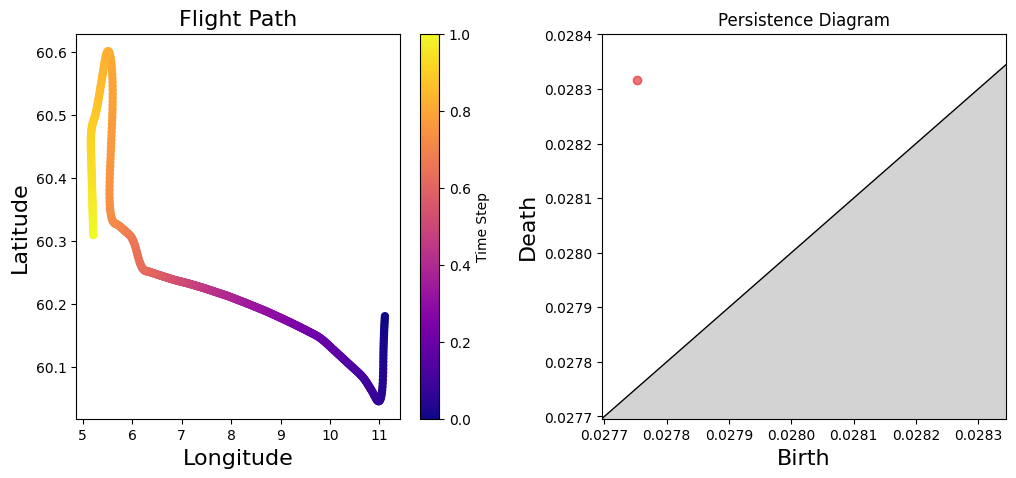

In [97]:
cluster = np.where(optic_clustering == 1)[0]
print(len(cluster))

fig = pers_data.plot_diagram(cluster[4])
